In [14]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import keras
import tensorflow as tf

In [15]:
# Temple resizing function
import numpy as np
#mport os
#import pandas as pd
#import random
import scipy.ndimage.interpolation as inter
from scipy.signal import medfilt 

#import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# utils.py
###################################################################################
    
    
#Rescale to be 64 frames
def zoom(p,target_l=64,joints_num=25,joints_dim=3):
    l = p.shape[0]
    p_new = np.empty([target_l,joints_num,joints_dim]) 
    for m in range(joints_num):
        for n in range(joints_dim):
            p[:,m,n] = medfilt(p[:,m,n],3)
            p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]         
    return p_new

def sampling_frame(p,C):
    full_l = p.shape[0] # full length
    if random.uniform(0,1)<0.5: # aligment sampling
        valid_l = np.round(np.random.uniform(0.9,1)*full_l)
        s = random.randint(0, full_l-int(valid_l))
        e = s+valid_l # sample end point
        p = p[int(s):int(e),:,:]    
    else: # without aligment sampling
        valid_l = np.round(np.random.uniform(0.9,1)*full_l)
        index = np.sort(np.random.choice(range(0,full_l),int(valid_l),replace=False))
        p = p[index,:,:]
    p = zoom(p,C.frame_l,C.joint_n,C.joint_d)
    return p

from scipy.spatial.distance import cdist
def get_CG(p,C):
    M = []
    iu = np.triu_indices(C.joint_n,1,C.joint_n)
    for f in range(C.frame_l):
        #distance max 
        d_m = cdist(p[f],np.concatenate([p[f],np.zeros([1,C.joint_d])]),'euclidean')       
        d_m = d_m[iu] 
        M.append(d_m)
    M = np.stack(M)   
    return M

def normlize_range(p):
    # normolize to start point, use the center for hand case
    p[:,:,0] = p[:,:,0]-np.mean(p[:,:,0])
    p[:,:,1] = p[:,:,1]-np.mean(p[:,:,1])
    p[:,:,2] = p[:,:,2]-np.mean(p[:,:,2])
    return p

def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(8,8)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                #annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
                annot[i, j] = '%.1f' % (p)
            elif c == 0:
                annot[i, j] = ''
            else:
                #annot[i, j] = '%.1f%%\n%d' % (p, c)
                annot[i, j] = '%.1f' % (p)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cbar=False, cmap="YlGnBu")
    plt.savefig(filename)

In [16]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [17]:

random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 12 # the number of joints
        self.joint_n = 22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 16 # ?? In the python notebook is 64, here is 16...
        self.data_dir = '/content/SHREC'
C = Config()

In [18]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...]) #tensorflow method 
    x = tf.image.resize(x,size=[H,W]) 
    return x

#calculate M_k_slow and M_k_fast
def pose_motion(P,frame_l):
    print("P type is:")
    print(type(P))
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)  #M_slow_[1,2,...,K - 1]
    P_fast = Lambda(lambda x: x[:,::2,...])(P) # S_0, S_2, S_5 ,... is P 1D?
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast) #M_fast_[1,2,...,K/2 - 1]
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    # Modeling Joint Correlations by an Embedding
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)


In [19]:
def build_DD_Net(frame_l=32,joint_n=22,joint_d=3,feat_d=231,clc_num=14,filters=16):
    M = Input(name='M', shape=(frame_l,feat_d))  
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) 
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.3)(x)
    x = Dense(clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [20]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_coarse,C.filters)
# DD_Net.summary()


P type is:
<class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>


In [21]:

Train = pickle.load(open("SHREC/train.pkl", "rb"))
Test = pickle.load(open("SHREC/test.pkl", "rb"))

In [22]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

100%|██████████| 1960/1960 [00:13<00:00, 143.53it/s]


In [23]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|██████████| 840/840 [00:05<00:00, 141.17it/s]


In [24]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)

history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

Epoch 1/600
1/1 [==============================] - 4s 4s/step - loss: 3.1639 - accuracy: 0.0628 - val_loss: 2.6388 - val_accuracy: 0.0786
Epoch 2/600
1/1 [==============================] - 0s 460ms/step - loss: 2.9297 - accuracy: 0.0893 - val_loss: 2.6389 - val_accuracy: 0.0655
Epoch 3/600
1/1 [==============================] - 0s 435ms/step - loss: 2.8158 - accuracy: 0.1128 - val_loss: 2.6393 - val_accuracy: 0.0655
Epoch 4/600
1/1 [==============================] - 0s 437ms/step - loss: 2.6761 - accuracy: 0.1296 - val_loss: 2.6397 - val_accuracy: 0.0655
Epoch 5/600
1/1 [==============================] - 0s 428ms/step - loss: 2.6167 - accuracy: 0.1434 - val_loss: 2.6404 - val_accuracy: 0.0655
Epoch 6/600
1/1 [==============================] - 0s 420ms/step - loss: 2.5849 - accuracy: 0.1536 - val_loss: 2.6413 - val_accuracy: 0.0655
Epoch 7/600
1/1 [==============================] - 0s 441ms/step - loss: 2.5082 - accuracy: 0.1658 - val_loss: 2.6424 - val_accuracy: 0.0655
Epoch 8/600
1/1 

Epoch 59/600
1/1 [==============================] - 0s 446ms/step - loss: 0.6203 - accuracy: 0.8138 - val_loss: 3.4616 - val_accuracy: 0.1036
Epoch 60/600
1/1 [==============================] - 0s 426ms/step - loss: 0.5700 - accuracy: 0.8372 - val_loss: 3.4751 - val_accuracy: 0.1000
Epoch 61/600
1/1 [==============================] - 0s 477ms/step - loss: 0.5606 - accuracy: 0.8418 - val_loss: 3.4888 - val_accuracy: 0.0845
Epoch 62/600
1/1 [==============================] - 0s 450ms/step - loss: 0.5632 - accuracy: 0.8316 - val_loss: 3.5023 - val_accuracy: 0.0845
Epoch 63/600
1/1 [==============================] - 0s 470ms/step - loss: 0.5263 - accuracy: 0.8566 - val_loss: 3.5197 - val_accuracy: 0.0821
Epoch 64/600
1/1 [==============================] - 0s 437ms/step - loss: 0.5281 - accuracy: 0.8469 - val_loss: 3.5377 - val_accuracy: 0.0798
Epoch 65/600
1/1 [==============================] - 0s 459ms/step - loss: 0.4929 - accuracy: 0.8566 - val_loss: 3.5601 - val_accuracy: 0.0798
Epoch 

1/1 [==============================] - 0s 436ms/step - loss: 0.2203 - accuracy: 0.9408 - val_loss: 4.0656 - val_accuracy: 0.1167
Epoch 117/600
1/1 [==============================] - 0s 421ms/step - loss: 0.2104 - accuracy: 0.9429 - val_loss: 4.0788 - val_accuracy: 0.1167
Epoch 118/600
1/1 [==============================] - 0s 453ms/step - loss: 0.2321 - accuracy: 0.9352 - val_loss: 4.0861 - val_accuracy: 0.1155
Epoch 119/600
1/1 [==============================] - 0s 485ms/step - loss: 0.1980 - accuracy: 0.9434 - val_loss: 4.0880 - val_accuracy: 0.1143
Epoch 120/600
1/1 [==============================] - 1s 510ms/step - loss: 0.2064 - accuracy: 0.9383 - val_loss: 4.0906 - val_accuracy: 0.1095
Epoch 121/600
1/1 [==============================] - 0s 430ms/step - loss: 0.1972 - accuracy: 0.9459 - val_loss: 4.0894 - val_accuracy: 0.1095
Epoch 122/600
1/1 [==============================] - 1s 507ms/step - loss: 0.2009 - accuracy: 0.9413 - val_loss: 4.0842 - val_accuracy: 0.1095
Epoch 123/600

1/1 [==============================] - 0s 416ms/step - loss: 0.1599 - accuracy: 0.9622 - val_loss: 4.0908 - val_accuracy: 0.1393
Epoch 174/600
1/1 [==============================] - 0s 418ms/step - loss: 0.1539 - accuracy: 0.9617 - val_loss: 4.0891 - val_accuracy: 0.1393
Epoch 175/600
1/1 [==============================] - 0s 407ms/step - loss: 0.1644 - accuracy: 0.9571 - val_loss: 4.0870 - val_accuracy: 0.1393
Epoch 176/600
1/1 [==============================] - 0s 408ms/step - loss: 0.1561 - accuracy: 0.9607 - val_loss: 4.0838 - val_accuracy: 0.1393
Epoch 177/600
1/1 [==============================] - 0s 418ms/step - loss: 0.1598 - accuracy: 0.9607 - val_loss: 4.0805 - val_accuracy: 0.1393
Epoch 178/600
1/1 [==============================] - 0s 417ms/step - loss: 0.1782 - accuracy: 0.9495 - val_loss: 4.0768 - val_accuracy: 0.1381
Epoch 179/600
1/1 [==============================] - 0s 410ms/step - loss: 0.1616 - accuracy: 0.9510 - val_loss: 4.0740 - val_accuracy: 0.1393
Epoch 180/600

1/1 [==============================] - 0s 402ms/step - loss: 0.1592 - accuracy: 0.9566 - val_loss: 3.8017 - val_accuracy: 0.1595
Epoch 231/600
1/1 [==============================] - 0s 425ms/step - loss: 0.1562 - accuracy: 0.9577 - val_loss: 3.7940 - val_accuracy: 0.1607
Epoch 232/600
1/1 [==============================] - 0s 437ms/step - loss: 0.1638 - accuracy: 0.9587 - val_loss: 3.7860 - val_accuracy: 0.1619
Epoch 233/600
1/1 [==============================] - 0s 433ms/step - loss: 0.1790 - accuracy: 0.9531 - val_loss: 3.7778 - val_accuracy: 0.1631
Epoch 234/600
1/1 [==============================] - 0s 421ms/step - loss: 0.1651 - accuracy: 0.9556 - val_loss: 3.7697 - val_accuracy: 0.1631
Epoch 235/600
1/1 [==============================] - 0s 414ms/step - loss: 0.1542 - accuracy: 0.9633 - val_loss: 3.7611 - val_accuracy: 0.1643
Epoch 236/600
1/1 [==============================] - 0s 431ms/step - loss: 0.1548 - accuracy: 0.9571 - val_loss: 3.7528 - val_accuracy: 0.1655
Epoch 237/600

1/1 [==============================] - 0s 409ms/step - loss: 0.1777 - accuracy: 0.9520 - val_loss: 3.1615 - val_accuracy: 0.2179
Epoch 288/600
1/1 [==============================] - 0s 404ms/step - loss: 0.1483 - accuracy: 0.9561 - val_loss: 3.1474 - val_accuracy: 0.2190
Epoch 289/600
1/1 [==============================] - 0s 395ms/step - loss: 0.1602 - accuracy: 0.9566 - val_loss: 3.1332 - val_accuracy: 0.2226
Epoch 290/600
1/1 [==============================] - 1s 550ms/step - loss: 0.1517 - accuracy: 0.9602 - val_loss: 3.1191 - val_accuracy: 0.2250
Epoch 291/600
1/1 [==============================] - 0s 470ms/step - loss: 0.1534 - accuracy: 0.9648 - val_loss: 3.1050 - val_accuracy: 0.2286
Epoch 292/600
1/1 [==============================] - 0s 475ms/step - loss: 0.1546 - accuracy: 0.9577 - val_loss: 3.0910 - val_accuracy: 0.2310
Epoch 293/600
1/1 [==============================] - 0s 416ms/step - loss: 0.1665 - accuracy: 0.9551 - val_loss: 3.0769 - val_accuracy: 0.2345
Epoch 294/600

1/1 [==============================] - 0s 423ms/step - loss: 0.1671 - accuracy: 0.9582 - val_loss: 2.3200 - val_accuracy: 0.3726
Epoch 345/600
1/1 [==============================] - 0s 412ms/step - loss: 0.1605 - accuracy: 0.9566 - val_loss: 2.3051 - val_accuracy: 0.3738
Epoch 346/600
1/1 [==============================] - 0s 409ms/step - loss: 0.1727 - accuracy: 0.9480 - val_loss: 2.2902 - val_accuracy: 0.3750
Epoch 347/600
1/1 [==============================] - 0s 399ms/step - loss: 0.1647 - accuracy: 0.9592 - val_loss: 2.2755 - val_accuracy: 0.3798
Epoch 348/600
1/1 [==============================] - 0s 393ms/step - loss: 0.1602 - accuracy: 0.9587 - val_loss: 2.2606 - val_accuracy: 0.3857
Epoch 349/600
1/1 [==============================] - 0s 415ms/step - loss: 0.1500 - accuracy: 0.9668 - val_loss: 2.2461 - val_accuracy: 0.3869
Epoch 350/600
1/1 [==============================] - 0s 415ms/step - loss: 0.1567 - accuracy: 0.9592 - val_loss: 2.2312 - val_accuracy: 0.3869
Epoch 351/600

1/1 [==============================] - 0s 411ms/step - loss: 0.1557 - accuracy: 0.9582 - val_loss: 1.5276 - val_accuracy: 0.5810
Epoch 402/600
1/1 [==============================] - 0s 406ms/step - loss: 0.1549 - accuracy: 0.9582 - val_loss: 1.5151 - val_accuracy: 0.5821
Epoch 403/600
1/1 [==============================] - 0s 406ms/step - loss: 0.1745 - accuracy: 0.9526 - val_loss: 1.5027 - val_accuracy: 0.5857
Epoch 404/600
1/1 [==============================] - 0s 402ms/step - loss: 0.1598 - accuracy: 0.9577 - val_loss: 1.4901 - val_accuracy: 0.5893
Epoch 405/600
1/1 [==============================] - 0s 410ms/step - loss: 0.1550 - accuracy: 0.9628 - val_loss: 1.4780 - val_accuracy: 0.5905
Epoch 406/600
1/1 [==============================] - 0s 401ms/step - loss: 0.1635 - accuracy: 0.9556 - val_loss: 1.4657 - val_accuracy: 0.5929
Epoch 407/600
1/1 [==============================] - 0s 412ms/step - loss: 0.1469 - accuracy: 0.9602 - val_loss: 1.4534 - val_accuracy: 0.5952
Epoch 408/600

1/1 [==============================] - 0s 410ms/step - loss: 0.1661 - accuracy: 0.9577 - val_loss: 0.9216 - val_accuracy: 0.7262
Epoch 459/600
1/1 [==============================] - 0s 413ms/step - loss: 0.1531 - accuracy: 0.9592 - val_loss: 0.9131 - val_accuracy: 0.7310
Epoch 460/600
1/1 [==============================] - 0s 404ms/step - loss: 0.1696 - accuracy: 0.9551 - val_loss: 0.9047 - val_accuracy: 0.7345
Epoch 461/600
1/1 [==============================] - 0s 400ms/step - loss: 0.1480 - accuracy: 0.9597 - val_loss: 0.8964 - val_accuracy: 0.7345
Epoch 462/600
1/1 [==============================] - 0s 406ms/step - loss: 0.1677 - accuracy: 0.9566 - val_loss: 0.8880 - val_accuracy: 0.7369
Epoch 463/600
1/1 [==============================] - 0s 402ms/step - loss: 0.1684 - accuracy: 0.9520 - val_loss: 0.8795 - val_accuracy: 0.7393
Epoch 464/600
1/1 [==============================] - 0s 406ms/step - loss: 0.1549 - accuracy: 0.9602 - val_loss: 0.8712 - val_accuracy: 0.7417
Epoch 465/600

1/1 [==============================] - 0s 416ms/step - loss: 0.1582 - accuracy: 0.9546 - val_loss: 0.5430 - val_accuracy: 0.8310
Epoch 516/600
1/1 [==============================] - 0s 408ms/step - loss: 0.1616 - accuracy: 0.9582 - val_loss: 0.5381 - val_accuracy: 0.8345
Epoch 517/600
1/1 [==============================] - 0s 405ms/step - loss: 0.1489 - accuracy: 0.9577 - val_loss: 0.5334 - val_accuracy: 0.8369
Epoch 518/600
1/1 [==============================] - 0s 409ms/step - loss: 0.1534 - accuracy: 0.9628 - val_loss: 0.5286 - val_accuracy: 0.8381
Epoch 519/600
1/1 [==============================] - 0s 412ms/step - loss: 0.1690 - accuracy: 0.9541 - val_loss: 0.5239 - val_accuracy: 0.8381
Epoch 520/600
1/1 [==============================] - 0s 408ms/step - loss: 0.1606 - accuracy: 0.9515 - val_loss: 0.5194 - val_accuracy: 0.8381
Epoch 521/600
1/1 [==============================] - 0s 415ms/step - loss: 0.1639 - accuracy: 0.9536 - val_loss: 0.5146 - val_accuracy: 0.8405
Epoch 522/600

1/1 [==============================] - 0s 391ms/step - loss: 0.1607 - accuracy: 0.9505 - val_loss: 0.3436 - val_accuracy: 0.8929
Epoch 573/600
1/1 [==============================] - 0s 406ms/step - loss: 0.1705 - accuracy: 0.9561 - val_loss: 0.3413 - val_accuracy: 0.8929
Epoch 574/600
1/1 [==============================] - 0s 410ms/step - loss: 0.1582 - accuracy: 0.9566 - val_loss: 0.3390 - val_accuracy: 0.8929
Epoch 575/600
1/1 [==============================] - 0s 413ms/step - loss: 0.1470 - accuracy: 0.9622 - val_loss: 0.3367 - val_accuracy: 0.8940
Epoch 576/600
1/1 [==============================] - 0s 416ms/step - loss: 0.1421 - accuracy: 0.9638 - val_loss: 0.3345 - val_accuracy: 0.8964
Epoch 577/600
1/1 [==============================] - 0s 404ms/step - loss: 0.1456 - accuracy: 0.9612 - val_loss: 0.3323 - val_accuracy: 0.8976
Epoch 578/600
1/1 [==============================] - 0s 404ms/step - loss: 0.1443 - accuracy: 0.9628 - val_loss: 0.3300 - val_accuracy: 0.8988
Epoch 579/600

In [25]:
DD_Net.save("DD_Net.h5")

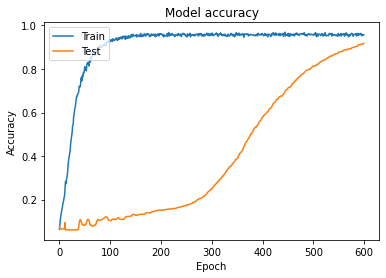

In [26]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()